<i>## Comments will be provided using this format. Key takeaway: groups are encouraged to change the formatting, but not the structure. Groups are also allowed to create additional notebooks - for instance, create one notebook for data exploration, and one notebook for each preprocessing-modelling-evaluation pipeline -, but must strive to keep an unified style across notebooks.</i>

#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Notebook Title`

#### Group:
- `Group member #1`
- `(...)`
- `Group member #5`

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [1. Data Understanding](#P1)
- [2. General Data Preparation](#P2) 
- [3. Multilabel Classification (Information Requirement 3311)](#P3)
    - [3.1 Specific Data Preparation](#P31)
    - [3.2 Model Implementation](#P32)
    - [3.3 Model Evaluation](#P3n)
- [4. Sentiment Analysis (Information Requirement 3312)](#P4)
    - [4.1 Specific Data Preparation](#P41)
    - [4.2 Model Implementation](#P42)
    - [4.3 Model Evaluation](#P43)
- [...]
- [N. Additional Tasks (Information Requirements 332n)](#Pn)
    - [N.1 Specific Data Preparation](#Pn1)
    - [N.2 Model Implementation](#Pn2)
    - [N.3 Model Evaluation](#Pn3)

<i>## Note that the notebook structure differs from the report: instead of following the CRISP-DM phases and then specifying the different problems inside the phases, the notebook is structured by problem, with the CRISP-DM phases being defined for each specific problem.

In [1]:
## All imports must be concentrated on a cell that immediately follow the table of contents
import time
import pandas as pd
from utils import pipeline_v1d
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

#without truncation
pd.set_option('display.max_colwidth', None)

<font color='#BFD72F' size=5>1. Data Understanding</font> <a class="anchor" id="P1"></a>
  
[Back to TOC](#toc)

<i>## Imports.</i>

In [2]:
reviews=pd.read_csv('data_hyderabad\\10k_reviews.csv')
restaurants=pd.read_csv('data_hyderabad\\105_restaurants.csv') 
restaurants = restaurants.drop(columns=['Links'])

## Restaurant data exploration


In [3]:
restaurants.head()

,Name,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,800,"Food Hygiene Rated Restaurants in Hyderabad, Corporate Favorites, Great Buffets, Top-Rated, Gold Curated, Live Sports Screenings","Chinese, Continental, Kebab, European, South Indian, North Indian","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Beverages",12 Noon to 2 AM
4,Over The Moon Brew Company,"1,200","Best Bars & Pubs, Food Hygiene Rated Restaurants in Hyderabad, Top-Rated, Gold Curated, Hyderabad's Hottest","Asian, Continental, North Indian, Chinese, Mediterranean","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12noon to 12midnight (Fri-Sat)"


In [4]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Cost         105 non-null    object
 2   Collections  51 non-null     object
 3   Cuisines     105 non-null    object
 4   Timings      104 non-null    object
dtypes: object(5)
memory usage: 4.2+ KB


### preproc Cost 

In [3]:
#Turning collunm cost to int
restaurants['Cost'] = restaurants['Cost'].str.replace(',', '').astype(int)

In [71]:
restaurants.describe()

,Cost
count,105.000000
mean,861.428571
std,510.149730
min,150.000000
25%,500.000000
50%,700.000000
75%,1200.000000
max,2800.000000


In [178]:
#there is no restaunt duplicates
restaurants['Name'].nunique()

105

### solving null value in  timming


In [4]:
restaurants[restaurants['Timings'].isnull()] #there is a missing value in timings
#After visiting tomato website we took the timetable of this restaurant
restaurants.loc[restaurants['Timings'].isnull(), 'Timings'] = '12AM to 3:30pm, 7pm to 11pm (Mon-Sun)'

### exploring cuisines and collections categories

In [5]:
# Putting this 2 collumns in a list
restaurants['Collections'] = restaurants['Collections'].str.lower().str.replace(r',\s+', ',', regex=True).str.split(',')
restaurants['Cuisines']=restaurants['Cuisines'].str.lower().str.replace(r',\s+', ',', regex=True).str.split(',')

In [ ]:
restaurants_exploded = restaurants.explode('Cuisines')
restaurants_exploded = restaurants_exploded.explode('Collections')

In [10]:
restaurant_agg = restaurants_exploded.groupby(['Cuisines', 'Collections']).agg(
    total_cost=('Cost', 'sum'), # Sum of 'Cost'
    count=('Cost', 'count')     # Count of restaurants
)

# Sort the result by 'total_cost' in descending order and get the top 10 rows
restaurant_agg.sort_values(by='total_cost', ascending=False).head(10)

total_cost  count
Cuisines     Collections                              
north indian great buffets                 8500      8
             corporate favorites           7800      6
italian      sunday brunches               7200      3
north indian live sports screenings        6900      6
asian        sunday brunches               6800      3
continental  sunday brunches               6800      3
north indian top-rated                     6700      5
             gold curated                  6700      5
             hyderabad's hottest           6300      5
             sunday brunches               6200      3

In [21]:
restaurants_exploded.groupby(['Collections']).agg(
    mean_cost=('Cost', 'mean'),   # Calculate the mean of 'Cost'
    count=('Cost', 'count') ).sort_values(by='mean_cost', ascending=False).head(5)

,mean_cost,count
Collections,,
ramzan mubarak,2500.000000,4
sunday brunches,2157.894737,19
function venues,2028.571429,7
great italian,1900.000000,5
great breakfasts,1642.857143,7


passar isto para função

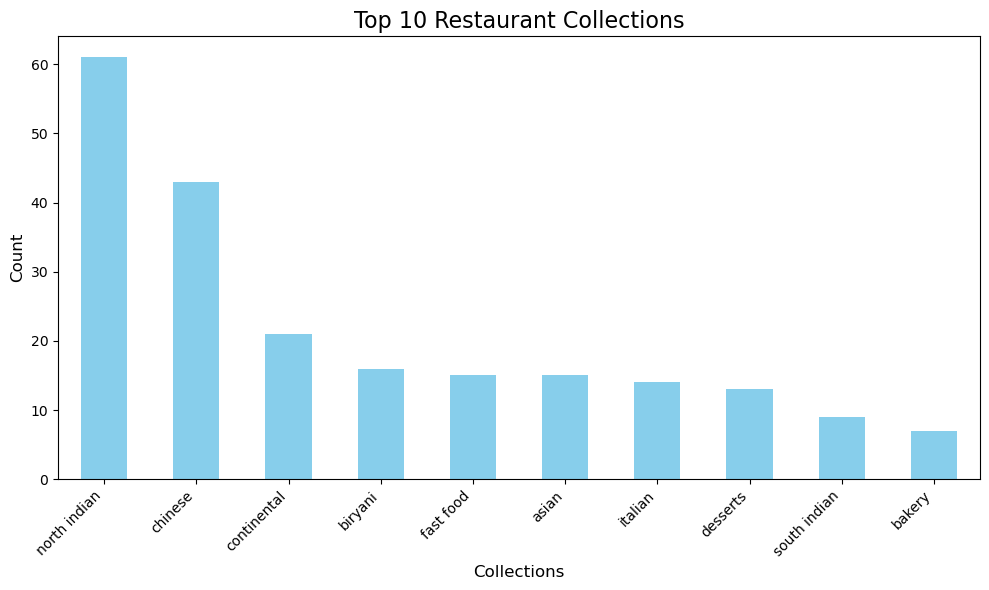

In [77]:
import matplotlib 
exploded_cuisines = restaurants['Cuisines'].explode()

# Step 2: Count the occurrences of each unique category
collection_counts = exploded_cuisines.value_counts()

# Step 3: Plot the top categories (you can adjust the number of top categories to show)
top_categories = collection_counts.head(10)  # Showing the top 10 categories

# Plot the bar chart
plt.figure(figsize=(10,6))
top_categories.plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Top 10 Restaurant Collections', fontsize=16)
plt.xlabel('Collections', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

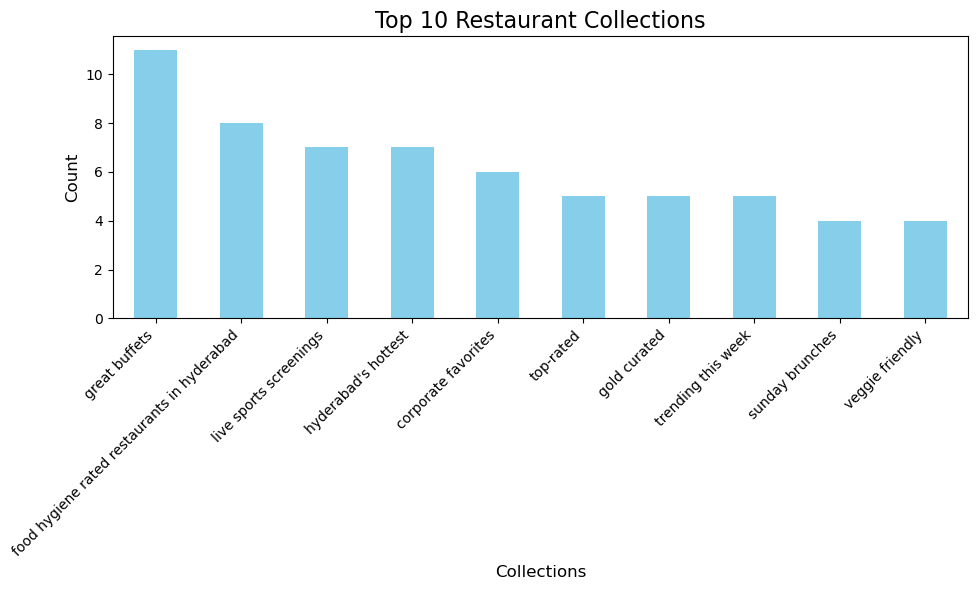

In [10]:
exploded_collections = restaurants['Collections'].explode()

# Step 2: Count the occurrences of each unique category
collection_counts = exploded_collections.value_counts()

# Step 3: Plot the top categories (you can adjust the number of top categories to show)
top_categories = collection_counts.head(10)  # Showing the top 10 categories

# Plot the bar chart
plt.figure(figsize=(10,6))
top_categories.plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Top 10 Restaurant Collections', fontsize=16)
plt.xlabel('Collections', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Preproc collections and cuisnes in binary vectors 

In [22]:
from sklearn.preprocessing import MultiLabelBinarizer

# Replace NaN values with empty lists
restaurants['Collections'] = restaurants['Collections'].apply(lambda x: x if isinstance(x, list) else [])


mlb = MultiLabelBinarizer()
one_hot_encoded = mlb.fit_transform(restaurants['Collections'])
# Add the one-hot encoded lists as a new column in the DataFrame
restaurants['encoded_Collections'] = one_hot_encoded.tolist()

one_hot_encoded = mlb.fit_transform(restaurants['Cuisines'])
restaurants['encoded_Cuisines'] = one_hot_encoded.tolist()


### Preproc timings 

In [29]:
import re

def capture_open_close_times(numbers_list):
    result = []
    for string in numbers_list:
        # Find all numbers in the string
        numbers = re.findall(r'\d+', string)
        if numbers:   
            # Capture the first (opening time) and determine closing time
            opening_time = numbers[0]
            if numbers[-1] in ('15', '30', '40'):
                closing_time = numbers[-2] if len(numbers) > 1 else None  # Use second-to-last if available
            else:
                closing_time = numbers[-1]  # Use last if not 15, 30, or 40

            # Transform closing time if it's 10, 11, or 12
            if closing_time == '10':
                closing_time = '22'
            elif closing_time == '11':
                closing_time = '23'
            elif closing_time == '12':
                closing_time = '24'

            # Transform opening time if it's 12, 1, 4, or 5
            elif opening_time == '1':
                opening_time = '13'
            elif opening_time == '4':
                opening_time = '16'
            elif opening_time == '5':
                opening_time = '17'

            # Append the transformed opening and closing times to the result
            result.append((opening_time, closing_time))

    return result

# Get a list of tuples (opening time, closing time)
open_close_times = capture_open_close_times(restaurants['Timings'])

# Unpack opening and closing times into separate lists
opening_times = [time[0] for time in open_close_times]
closing_times = [time[1] for time in open_close_times]

# Assign the lists to new columns in the DataFrame
restaurants['open time'] = opening_times
restaurants['closing time'] = closing_times

In [52]:
restaurants['Timings']

0                                 12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)
1                                                                11 AM to 11 PM
2                                         11:30 AM to 4:30 PM, 6:30 PM to 11 PM
3                                                               12 Noon to 2 AM
4      12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12noon to 12midnight (Fri-Sat)
                                         ...                                   
100                                                              11 AM to 11 PM
101                        10 AM to 10 PM (Mon-Thu), 8 AM to 10:30 PM (Fri-Sun)
102                                                            12 Noon to 11 PM
103                                                    8am to 12:30AM (Mon-Sun)
104                                       11:30 AM to 3 PM, 7 PM to 12 Midnight
Name: Timings, Length: 105, dtype: object

## Reviews data exploration


In [142]:
reviews[reviews.duplicated(keep=False)]

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
8777,American Wild Wings,NaN,NaN,NaN,NaN,NaN,0
8778,American Wild Wings,NaN,NaN,NaN,NaN,NaN,0
8779,American Wild Wings,NaN,NaN,NaN,NaN,NaN,0
8780,American Wild Wings,NaN,NaN,NaN,NaN,NaN,0
8781,American Wild Wings,NaN,NaN,NaN,NaN,NaN,0
8782,American Wild Wings,NaN,NaN,NaN,NaN,NaN,0
8783,American Wild Wings,NaN,NaN,NaN,NaN,NaN,0
8784,American Wild Wings,NaN,NaN,NaN,NaN,NaN,0
8785,American Wild Wings,NaN,NaN,NaN,NaN,NaN,0
8786,American Wild Wings,NaN,NaN,NaN,NaN,NaN,0


In [141]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


In [52]:
print('How many times a reviewer posted')
reviews['Reviewer'].value_counts().sort_values(ascending=False)

How many times a reviewer posted


Parijat Ray              13
Ankita                   13
Kiran                    12
Vedant Killa             11
Jay Mehta                11
                         ..
Manish Singh              1
Kshitiz Goyal             1
Deepali K. Nagrani        1
Laxminarayana Amuraji     1
Bhargava Krishna          1
Name: Reviewer, Length: 7446, dtype: int64

In [53]:
print('How many reviews each restaurant has')
reviews['Restaurant'].value_counts().sort_values(ascending=True)

How many reviews each restaurant has


Beyond Flavours                   100
Shah Ghouse Hotel & Restaurant    100
Over The Moon Brew Company        100
The Fisherman's Wharf             100
eat.fit                           100
                                 ... 
Triptify                          100
Squeeze @ The Lime                100
The Old Madras Baking Company     100
Arena Eleven                      100
Chinese Pavilion                  100
Name: Restaurant, Length: 100, dtype: int64

In [45]:
# Extract the number of reviews, followers
reviews['Review'] = reviews['Metadata'].str.extract(r'(\d+)\s+Review')
reviews['Followers'] = reviews['Metadata'].str.extract(r'(\d+)\s+Follower')

reviews['Review'] = pd.to_numeric(reviews['Review'])
reviews['Followers'] = pd.to_numeric(reviews['Followers'])
reviews=reviews.drop('Metadata', axis=1)

In [ ]:
reviews.groupby('Restaurant').sum(['Rating',''])

In [46]:
reviews

,Restaurant,Reviewer,Review,Rating,Time,Pictures,Followers
0,Beyond Flavours,Rusha Chakraborty,1.0,5,5/25/2019 15:54,0,2.0
1,Beyond Flavours,Anusha Tirumalaneedi,3.0,5,5/25/2019 14:20,0,2.0
2,Beyond Flavours,Ashok Shekhawat,2.0,5,5/24/2019 22:54,0,3.0
3,Beyond Flavours,Swapnil Sarkar,1.0,5,5/24/2019 22:11,0,1.0
4,Beyond Flavours,Dileep,3.0,5,5/24/2019 21:37,0,2.0
...,...,...,...,...,...,...,...
9995,Chinese Pavilion,Abhishek Mahajan,53.0,3,6/5/2016 0:08,0,54.0
9996,Chinese Pavilion,Sharad Agrawal,2.0,4.5,6/4/2016 22:01,0,53.0
9997,Chinese Pavilion,Ramandeep,65.0,1.5,6/3/2016 10:37,3,423.0
9998,Chinese Pavilion,Nayana Shanbhag,13.0,4,5/31/2016 17:22,0,144.0


In [40]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  10000 non-null  object 
 1   Reviewer    9962 non-null   object 
 2   Review      9956 non-null   float64
 3   Rating      9962 non-null   object 
 4   Time        9962 non-null   object 
 5   Pictures    10000 non-null  int64  
 6   Followers   8384 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 547.0+ KB


In [12]:
reviews["preproc_Review"] = reviews["Review"].apply(lambda review : pipeline_v1d.main_pipeline(review,\
                                                                                         print_output=False,\
                                                                                            lemmatized=False,\
                                                                                            no_stopwords=True,\
                                                                                            tokenized_output=True,\
                                                                                            custom_stopwords=[]))

reviews = reviews["preproc_sentences"].tolist()

TypeError: expected string or bytes-like object